In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'

In [2]:
import jax
import jax.numpy as np
import jax.tree_util as jtu

key = jax.random.PRNGKey(1)

jax.config.update("jax_debug_nans", True)
jax.config.update("jax_enable_x64", True)

import jax_md
import equinox as eqx

import jax_morph as jxm
from jax_morph.visualization import draw_circles_divrate, draw_circles_chem, draw_circles_stress, draw_circles_ctype

import matplotlib.pyplot as plt

# Cell State

In [3]:
#all new cell states must inherit from jxm.BaseCellState
class CellState(jxm.BaseCellState):
    chemical:           jax.Array
    secretion_rate:     jax.Array
    chemical_grad:      jax.Array
    hidden_state:       jax.Array

In [258]:
N_DIM = 2
N_CHEM = 3
N_HIDDEN = 16 #16
N_CTYPES = 1

N = 120
N_ADD = int(N-1)


### Build initial state

disp, shift = jax_md.space.free()

istate = CellState(
    displacement=   disp,
    shift=          shift,
    position=       np.zeros(shape=(N,N_DIM)),
    celltype=       np.zeros(shape=(N,N_CTYPES)).at[0].set(1.),
    radius=         np.zeros(shape=(N,1)).at[0].set(.5),
    division=       np.zeros(shape=(N,1)).at[0].set(1.),
    chemical=       np.zeros(shape=(N,N_CHEM)),
    chemical_grad=  np.zeros(shape=(N,int(N_DIM*N_CHEM))),
    secretion_rate= np.zeros(shape=(N,N_CHEM)).at[0].set(1.),
    hidden_state=   np.zeros(shape=(N,N_HIDDEN))
)

# Model

**NOTE 1:** Every parameter that is passed as a jax array will be differentiated over and subject to optimization. Every parameter that is passed as a python primitive will be treated as a constant.

**NOTE 2:** There is currently no (easy) way to do the opposite in jax-morph, that is to choose *not* to differentiate w.r.t. a jax array. It is possible in principle but doesn't look like we used this feature that much until now, so its introduction is postponed.

In [239]:
# key, init_key = jax.random.split(key)


mech_potential = jxm.env.mechanics.MorsePotential(epsilon=3., alpha=2.8)

model = jxm.Sequential(
    substeps=[
        jxm.env.CellDivision(),

        jxm.env.CellGrowth(growth_rate=.03, max_radius=.5, growth_type='linear'),

        jxm.env.mechanics.SGDMechanicalRelaxation(mech_potential),

        # jxm.env.SteadyStateDiffusion(degradation_rate=.1, diffusion_coeff=1.),
        jxm.env.diffusion.ApproxSteadyStateDiffusion(degradation_rate=.5, diffusion_coeff=.5),

        jxm.cell.sensing.LocalChemicalGradients(),

        jxm.cell.GeneNetwork(istate,
                            input_fields=['chemical', 'chemical_grad', 'division', 'radius'],
                            output_fields=['secretion_rate', 'division'],
                            key=init_key,
                            transform_output={'division': lambda s,x: x*jax.nn.sigmoid(50*(s.radius - .45))},
                            expr_level_decay=.8,
                            ),

    ])


# POSSIBLE REASONS FOR NOT WORKING IN GENERAL:
# - sigmoids in the gene network
# - too small number of params in the gene network
# - gradient problems in the gene network (possibly connected to the sigmoids)

In [318]:
# ### WORKS VERY WELL



# key, init_key = jax.random.split(key)


mech_potential = jxm.env.mechanics.MorsePotential(epsilon=3., alpha=2.8)

model = jxm.Sequential(
    substeps=[
        jxm.env.CellDivision(),

        jxm.env.CellGrowth(growth_rate=.03, max_radius=.5, growth_type='linear'),

        jxm.env.mechanics.SGDMechanicalRelaxation(mech_potential),

        jxm.env.SteadyStateDiffusion(degradation_rate=.1, diffusion_coeff=1.), #WORKS LESS WELL, BUT STILL WORKS -- ???
        # jxm.env.diffusion.ApproxSteadyStateDiffusion(degradation_rate=.5, diffusion_coeff=.5),

        jxm.cell.sensing.LocalChemicalGradients(),

        jxm.cell.HiddenStateMLP(istate,
                                input_fields=['chemical', 'chemical_grad', 'division', 'radius'],
                                layer_width=128,
                                num_mlp_hidden_layers=1,
                                key=init_key,
        ),

        jxm.cell.SecretionMLP(istate,
                              input_fields=['hidden_state'],
                              key=init_key,
        ),


        jxm.cell.DivisionMLP(istate,
                             input_fields=['hidden_state'],
                             key=init_key,
                             w_init=jax.nn.initializers.glorot_normal(),
                             transform_output=lambda s,x: x*jax.nn.sigmoid(50*(s.radius - .45)),
        ),

    ])

# REINFORCE Loss

In [241]:
from functools import partial

In [242]:
@eqx.filter_jit
def reinforce_loss(model, istate, *, cost_fn, key, n_steps=1, BATCH_SIZE=1, GAMMA=.9, LAMBDA=.001):

    subkeys = jax.random.split(key, BATCH_SIZE)
    subkeys = np.asarray(subkeys)

    vsim = jax.vmap(partial(jxm.simulate, history=True), (None, None, 0, None))
    trajectory, logp = vsim(model, istate, subkeys, n_steps)


    istate = jtu.tree_map(lambda x: np.repeat(x[None,None,:,:],BATCH_SIZE,0), istate)

    trajectory = jtu.tree_map(lambda *v: np.concatenate(v,1), *[istate, trajectory])


    cost = jax.vmap(cost_fn)(trajectory)


    #discounted costs
    def _returns_rec(rewards):
        Gs=[]
        G=0
        for r in rewards[::-1]:
            G = r+G*GAMMA
            Gs.append(G)

        return np.array(Gs)[::-1]
    
    
    cost = jax.vmap(_returns_rec)(cost)

    cost = (cost-cost.mean(-1, keepdims=True))/(cost.std(-1, keepdims=True)+1e-8)


    #no - sign because we assume a cost instead of a reward
    loss = np.sum(jax.lax.stop_gradient(cost)*logp)


    #L1 penalty on weights
    reg = jax.tree_map(lambda x: np.abs(x).sum(), eqx.filter(model, eqx.is_array))
    reg = jax.tree_util.tree_reduce(lambda x,y: x+y, reg)

    return loss + LAMBDA*reg

## Cost Functions

In [348]:
def v_shape(trajectory, diff=True):

    def _state_cost(state):
        pos = state.position
        mask = (pos[:,1]+1.5 > .5*np.abs(pos[:,0])) * (pos[:,1]+1.5 < 3.5+.5*np.abs(pos[:,0])) * (pos[:,1]>-.1)

        c = np.sum(np.where(mask, 0., 3.) * state.celltype.sum(-1))

        return c


    cost = jax.vmap(_state_cost)(trajectory)

    cost += .1 * np.abs(trajectory.position[:,:,0].sum(-1))

    if diff:
        cost = np.diff(cost)

    return cost

# Training

In [294]:
import optax
from tqdm import trange
from functools import partial

In [334]:
EPOCHS = 150
BATCH_SIZE = 8


COST_FN = v_shape
LAMBDA=0.


opt_model = model


optimizer = optax.adam(5e-4)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

key, subkey = jax.random.split(key)

rl, g = eqx.filter_jit(eqx.filter_value_and_grad(reinforce_loss))(opt_model, istate, cost_fn=COST_FN, key=subkey, n_steps=N_ADD, BATCH_SIZE=BATCH_SIZE, LAMBDA=LAMBDA)

l = eqx.filter_jit(COST_FN)(jxm.simulate(opt_model, istate, subkey, N_ADD, history=True)[0]).sum()


rlosses = [float(rl)]
losses = [float(l)]

pbar = trange(EPOCHS)
for e in pbar:

    try:
        g = jax.tree_map(lambda x: x/(np.linalg.norm(x)+1e-10), g)

        updates, opt_state = optimizer.update(g, opt_state, opt_model)
        opt_model = eqx.apply_updates(opt_model, updates)

        key, subkey = jax.random.split(key)

        rl, g = eqx.filter_jit(eqx.filter_value_and_grad(reinforce_loss))(opt_model, istate, cost_fn=COST_FN, key=subkey, n_steps=N_ADD, BATCH_SIZE=BATCH_SIZE, LAMBDA=LAMBDA)

        l = eqx.filter_jit(COST_FN)(jxm.simulate(opt_model, istate, subkey, N_ADD, history=True)[0]).sum()


        rlosses.append(float(rl))
        losses.append(float(l))
        pbar.set_description(f'Loss: {l:.3f}')

    except FloatingPointError:
        print('NaN or Overflow')
        break

    except KeyboardInterrupt:
        print('Interrupted')
        break

Loss: 103.294: 100%|██████████████████████████| 150/150 [01:45<00:00,  1.42it/s]


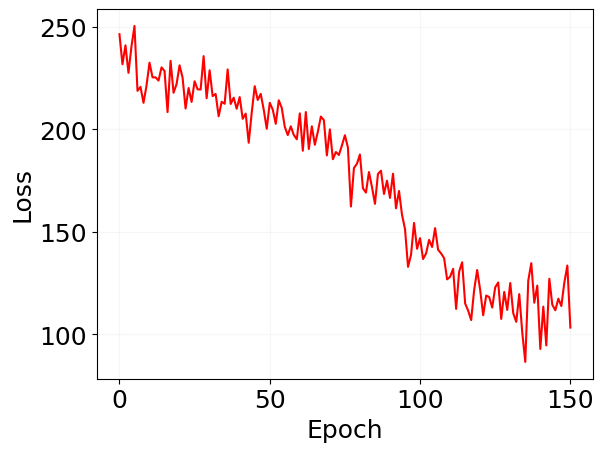

In [335]:
plt.plot(losses, 'r')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.grid(alpha=.1);

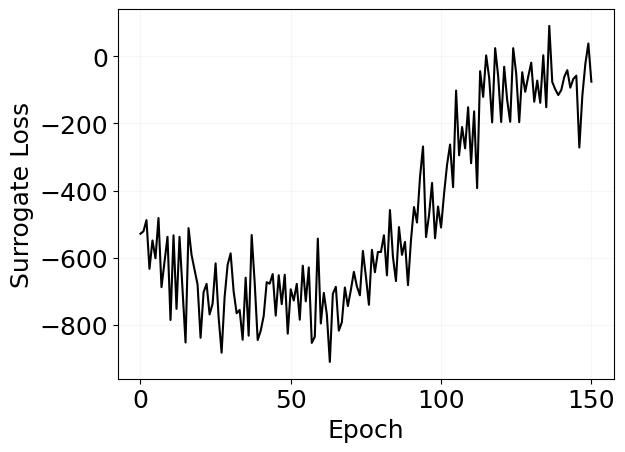

In [336]:
plt.plot(rlosses, 'k')

plt.xlabel('Epoch')
plt.ylabel('Surrogate Loss')

plt.grid(alpha=.1);

In [349]:
def _final_cost_distribution(model, istate, subkeys, n_sim_steps, cost_fn):

    vsim = jax.vmap(jxm.simulate, (None, None, 0, None))

    fstate, _ = vsim(model, istate, subkeys, n_sim_steps)

    cost = cost_fn(fstate, diff=False)

    return cost.tolist()

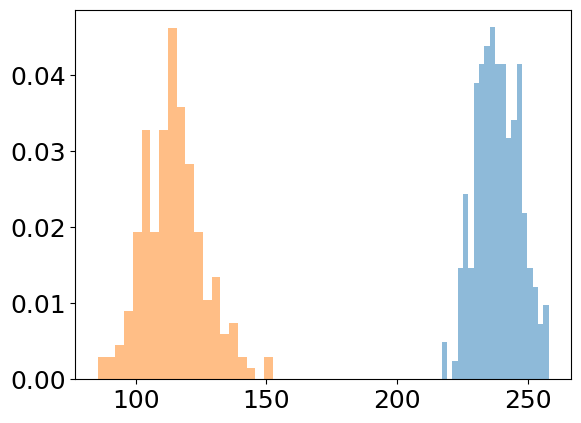

In [352]:
subkeys = np.asarray(jax.random.split(key, 200))

mcost = _final_cost_distribution(model, istate, subkeys, N_ADD, COST_FN)
ocost = _final_cost_distribution(opt_model, istate, subkeys, N_ADD, COST_FN)

plt.hist(mcost, bins=20, alpha=.5, density=True)
plt.hist(ocost, bins=20, alpha=.5, density=True);

# Initial Random Parameters

In [252]:
key, subkey = jax.random.split(key)
ss, _ = jxm.simulate(model, istate, subkey, N_ADD)

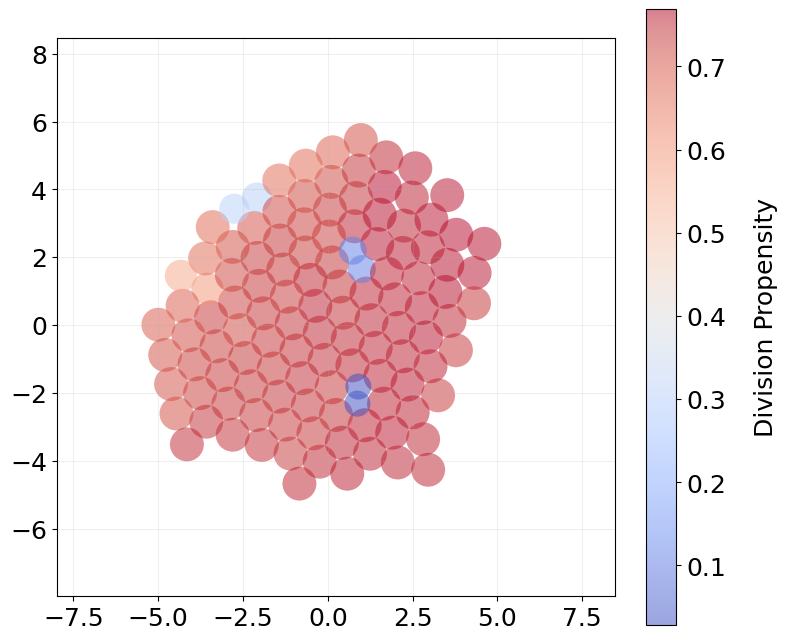

In [253]:
draw_circles_divrate(ss, grid=True);

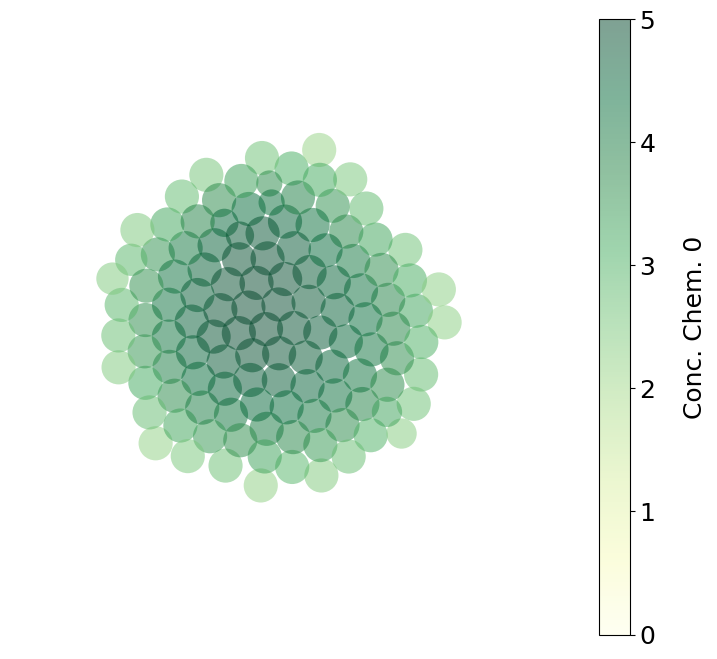

In [251]:
draw_circles_chem(ss, 0);

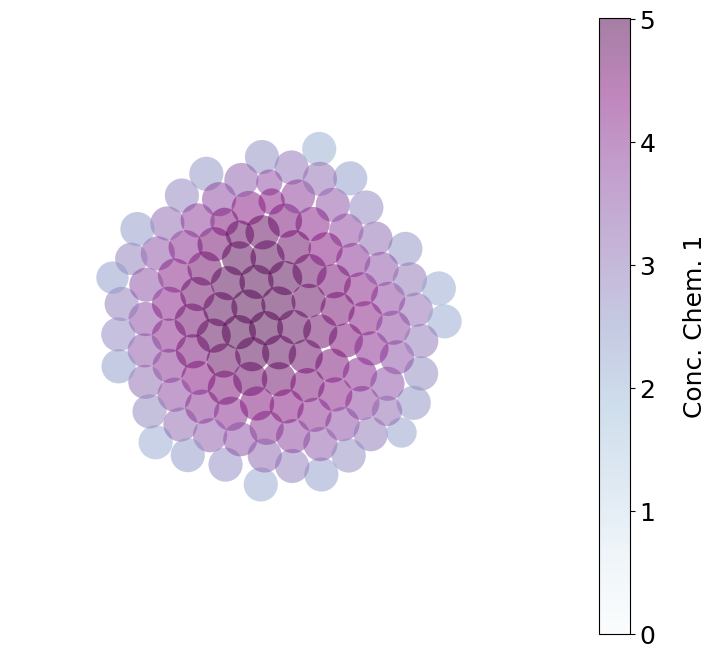

In [19]:
draw_circles_chem(ss, 1);

In [86]:
mat = model[-1].interaction_matrix

v = np.max(np.abs(mat))

plt.imshow(mat, cmap='bwr', vmin=-v, vmax=v)
plt.colorbar();

AttributeError: 'DivisionMLP' object has no attribute 'interaction_matrix'

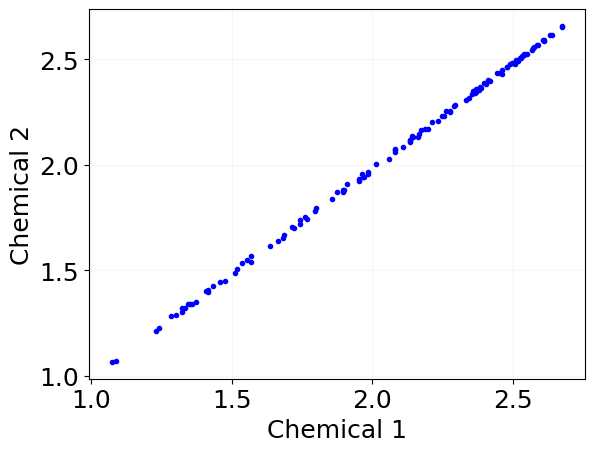

In [87]:
plt.plot(ss.chemical[:,0].tolist(), ss.chemical[:,1].tolist(), 'b.')

plt.xlabel('Chemical 1')
plt.ylabel('Chemical 2')

plt.grid(alpha=.1);

# Optimized Parameters

In [339]:
key, subkey = jax.random.split(key)
s, _ = jxm.simulate(opt_model, istate, subkey, N_ADD)

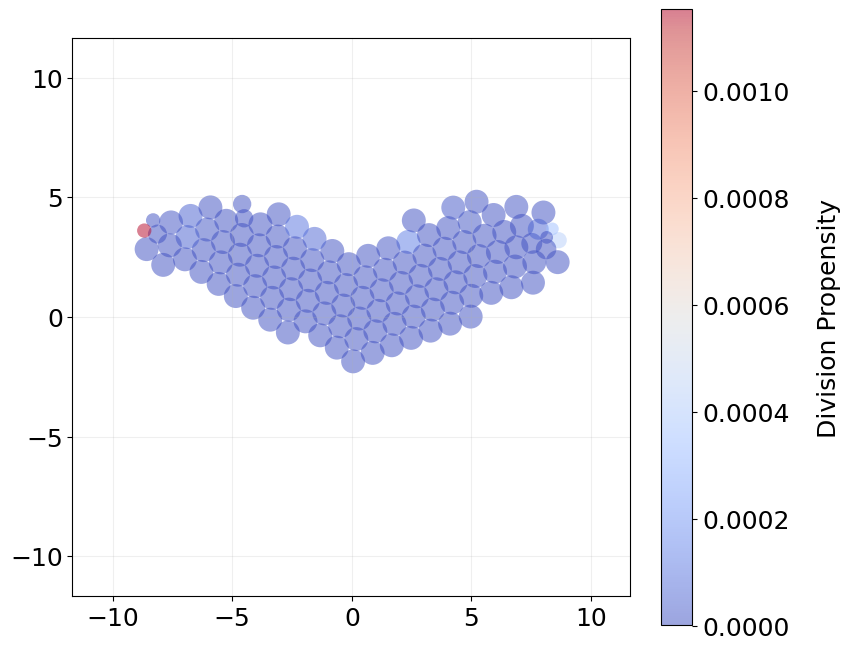

In [340]:
draw_circles_divrate(s, grid=True);

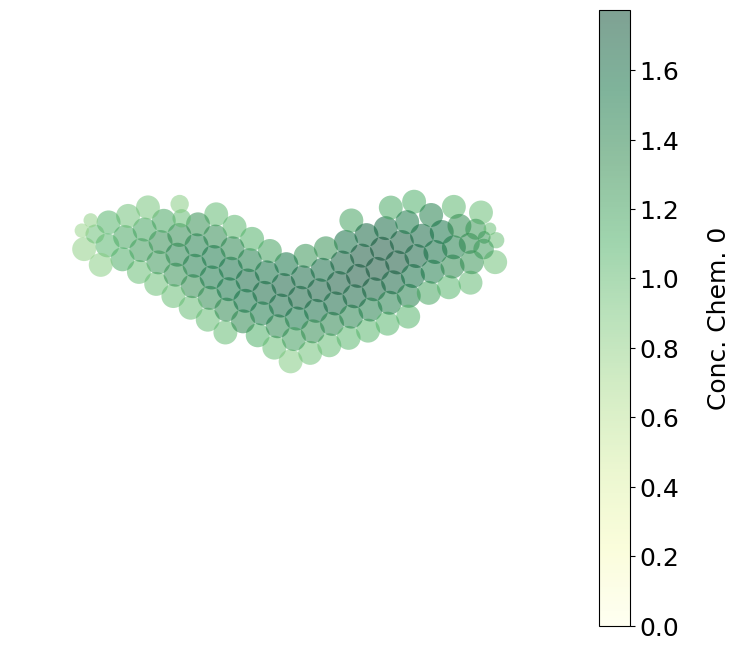

In [341]:
draw_circles_chem(s, 0);

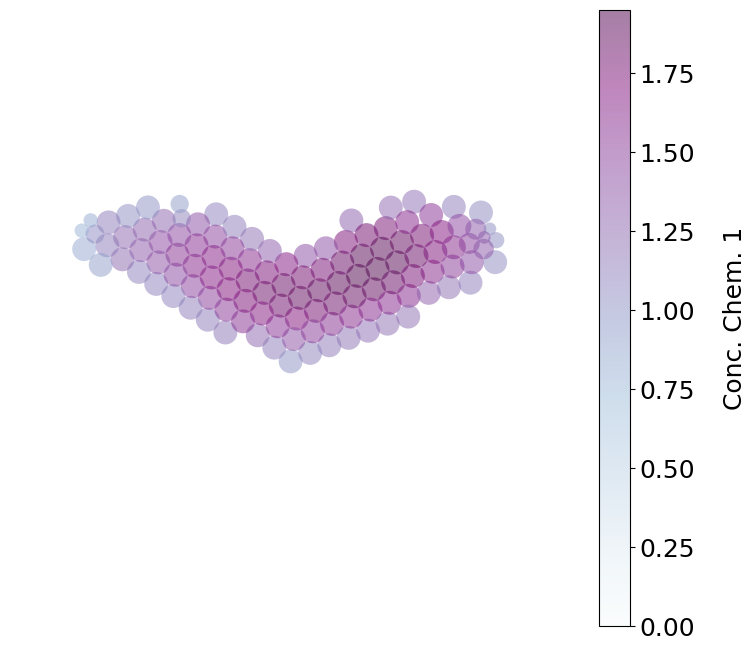

In [342]:
draw_circles_chem(s, 1);

In [92]:
mat = opt_model[-1].interaction_matrix

v = np.max(np.abs(mat))

plt.imshow(mat, cmap='bwr', vmin=-v, vmax=v)
plt.colorbar();

AttributeError: 'DivisionMLP' object has no attribute 'interaction_matrix'

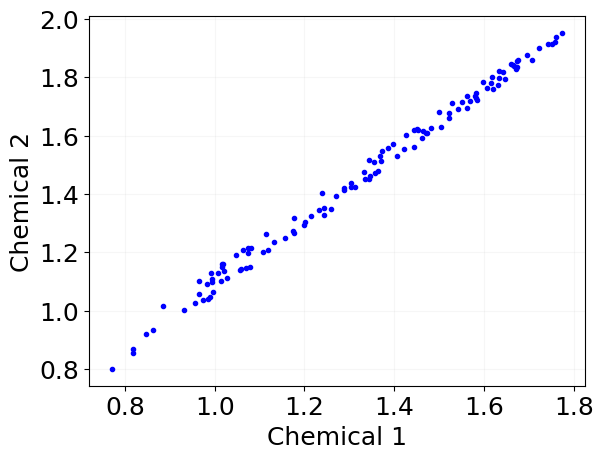

In [343]:
plt.plot(s.chemical[:,0].tolist(), s.chemical[:,1].tolist(), 'b.')

plt.xlabel('Chemical 1')
plt.ylabel('Chemical 2')

plt.grid(alpha=.1);

In [220]:
ss1 = jxm.env.SteadyStateDiffusion(degradation_rate=.1, diffusion_coeff=1.)(s)
ss2 = jxm.env.diffusion.ApproxSteadyStateDiffusion(degradation_rate=.8, diffusion_coeff=.5)(s)

In [221]:
ss3, _ = opt_model(s, key=subkey)

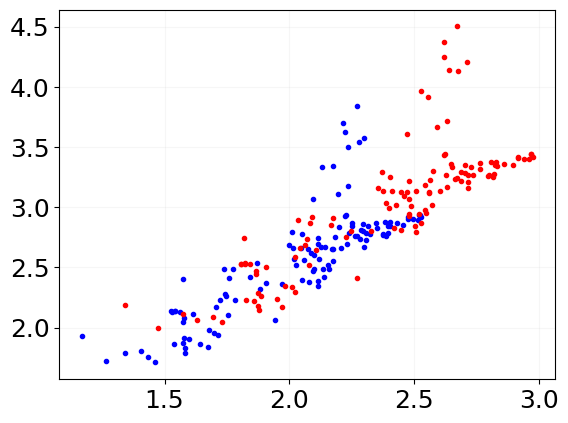

In [222]:
plt.plot(ss1.chemical[:,0].tolist(), ss2.chemical[:,0].tolist(), 'b.')
plt.plot(ss1.chemical[:,1].tolist(), ss2.chemical[:,1].tolist(), 'r.')

plt.grid(alpha=.1);

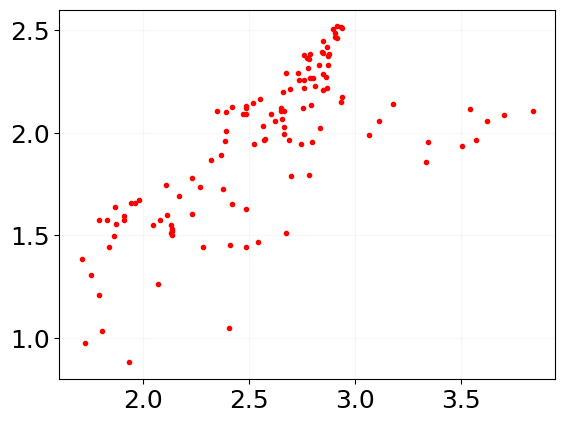

In [223]:
plt.plot(ss2.chemical[:,0].tolist(), ss3.chemical[:,0].tolist(), 'r.')

plt.grid(alpha=.1);


In [ ]:
    # if realign:

    #     @jax.vmap
    #     def _realign(pos):
    #         _, P = np.linalg.eigh(np.cov(pos.T))
    #         return pos @ P[:,::-1]

    #     pos = _realign(trajectory.position)

    # else:
    #     pos = trajectory.position